##### Imports

Primary references: https://www.kaggle.com/sevvalbicer/dense-net-dog-image-classification#Testing (herein referred to as DenseRef) and https://www.kaggle.com/michaelfumery/computer-vision-cnn-stanford-dogs-dataset (herein referred to as XceptRef).

In [43]:
import os, cv2
import numpy as np
import tensorflow as tf
from tensorflow.python import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,  AveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from PIL import Image

from tensorflow.python.client import device_lib

### Data Loading and Analysis

Number of breeds in dataset: 120


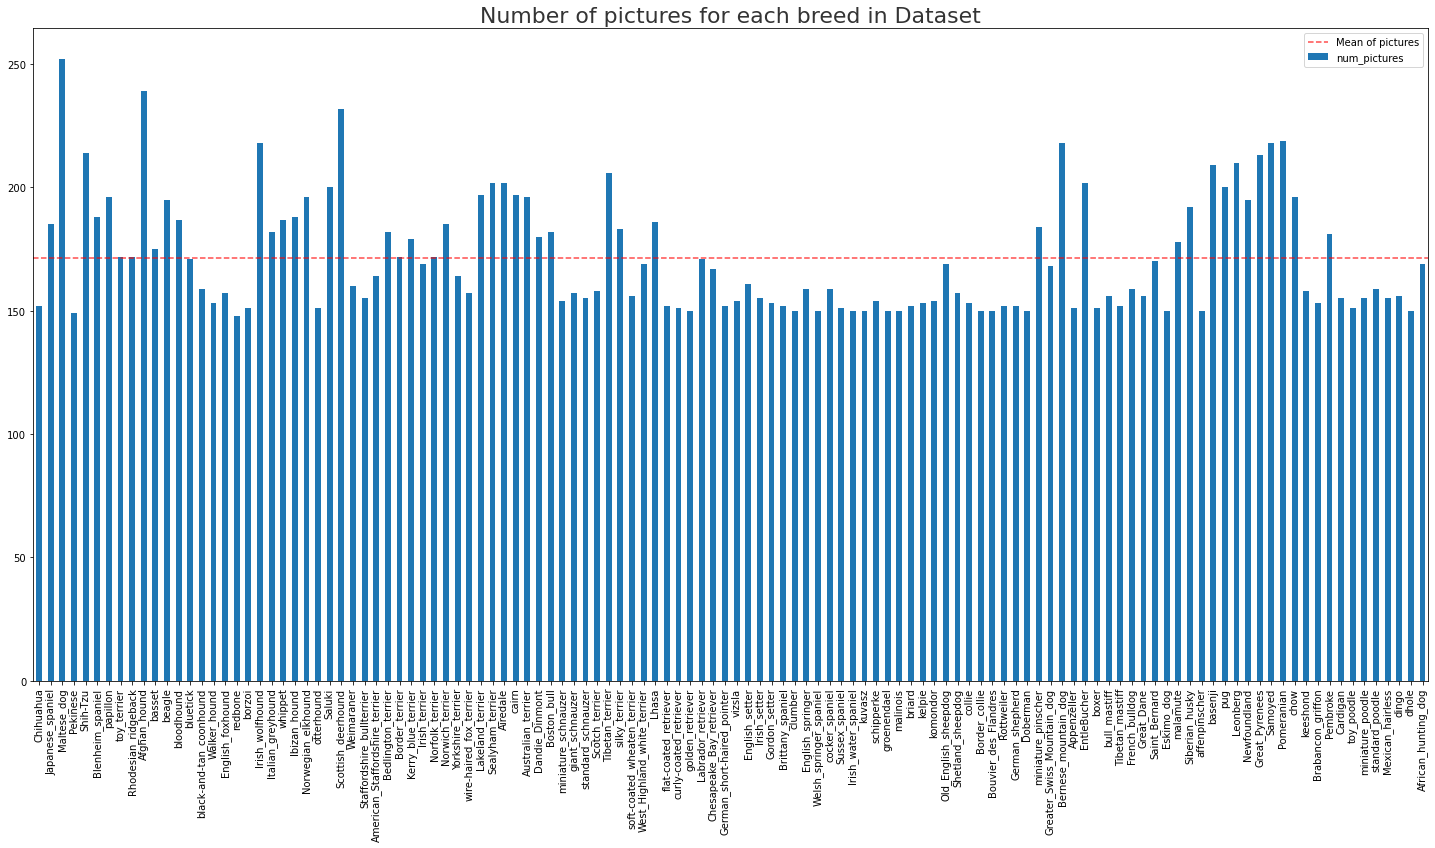

In [23]:
import pandas as pd
#From XceptRef

#Define paths
images_dir = "./input/stanford-dogs-dataset/images/Images/"
annotations_dir = '../input/stanford-dogs-dataset/annotations/Annotation'

# Count the number of classes (dogs breeds)
breed_list = os.listdir(images_dir)
print("Number of breeds in dataset:", (len(breed_list)))

#From XceptRef
# Count number of pictures for each breed
df_breeds = pd.DataFrame(
    index=[breed.split('-',1)[1] for breed in breed_list],
    data=[len(os.listdir(images_dir + "/" + name)) for name in breed_list],
    columns=["num_pictures"])

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(25,12))
df_breeds.plot(kind="bar",legend=False, ax=ax)
ax.axhline(df_breeds["num_pictures"].mean(), color='r', alpha=.7, linestyle='--', label="Mean of pictures")
plt.title("Number of pictures for each breed in Dataset", color="#343434", fontsize=22)
plt.legend()
plt.show()

In [24]:
#From DenseRef with modifications - load categories
categories = [
    'n02096294-Australian_terrier',
    'n02093256-Staffordshire_bullterrier',
    'n02099601-golden_retriever',
    'n02106662-German_shepherd',
    'n02086240-Shih-Tzu',
    'n02099712-Labrador_retriever',
    'n02088364-beagle',
    'n02100735-English_setter',
    'n02102318-cocker_spaniel',
    'n02108915-French_bulldog',
    'n02094433-Yorkshire_terrier',
    'n02085620-Chihuahua',
    'n02110185-Siberian_husky',
    'n02106166-Border_collie',
    'n02106550-Rottweiler']
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))


List of categories =  ['n02096294-Australian_terrier', 'n02093256-Staffordshire_bullterrier', 'n02099601-golden_retriever', 'n02106662-German_shepherd', 'n02086240-Shih-Tzu', 'n02099712-Labrador_retriever', 'n02088364-beagle', 'n02100735-English_setter', 'n02102318-cocker_spaniel', 'n02108915-French_bulldog', 'n02094433-Yorkshire_terrier', 'n02085620-Chihuahua', 'n02110185-Siberian_husky', 'n02106166-Border_collie', 'n02106550-Rottweiler'] 

No. of categories =  15


DenseRef limited their project to the first 20 categories. 

As XceptRef pointed out, the categories are all well-represented such that the classes should be equal enough to all be used. XceptRef used 15 of the 20 most popular dog breeds in France for their categories. We'll start by testing DenseRef on these 15 breeds so the results are more comparable, but after we'll randomize them as should be done for proper experimental methodology.

Let's take a look at what some of these (random) images look like.

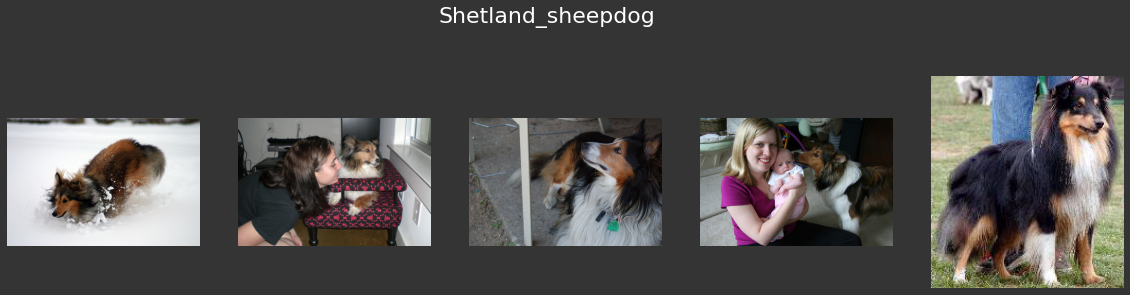

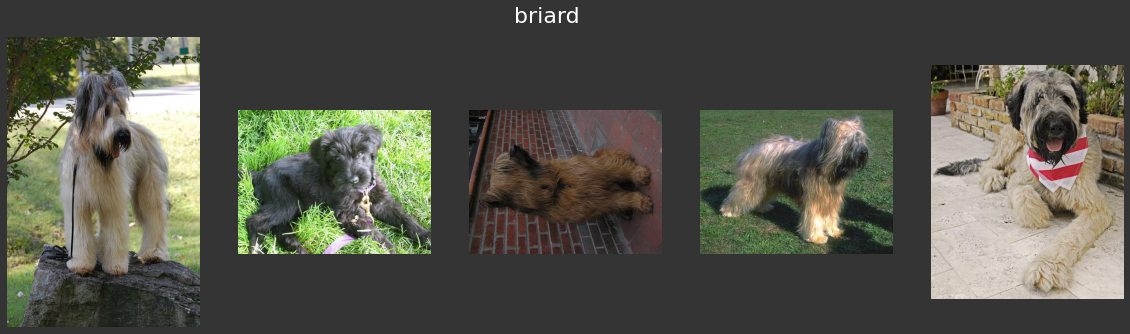

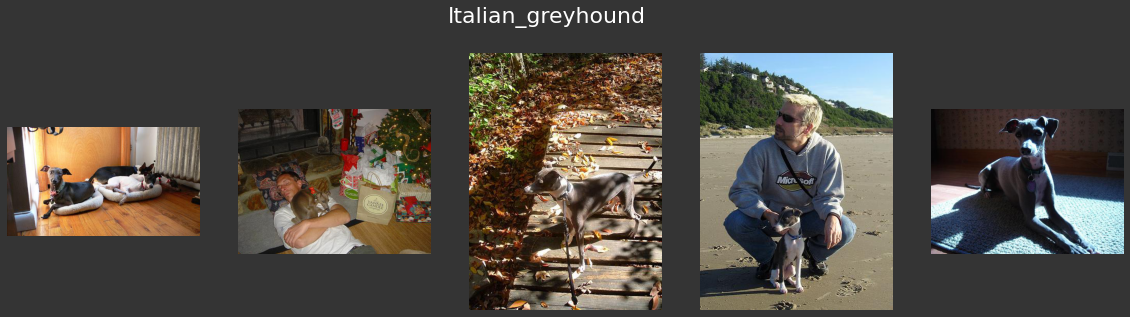

In [25]:
#From XceptRef
def show_images_classes(path, classes, num_sample):
    """This function is used to display the first 
    n images of a directory passed as an argument. 
    It is adapted to subdirectories. 
    
    The matplotlib.image library must be loaded 
    with the alias mpimg. 

    Parameters
    ----------------------------------------
    path : string
        Link of root directory
    classes : string 
        Name of the subdirectory
    num_smaple : integer
        Number of picture to show
    ----------------------------------------
    """
    fig = plt.figure(figsize=(20,20))
    fig.patch.set_facecolor('#343434')
    plt.suptitle("{}".format(classes.split("-")[1]), y=.83,
                 color="white", fontsize=22)
    images = os.listdir(path + "/" + classes)[:num_sample]
    for i in range(num_sample):
        img = mpimg.imread(path+"/"+classes+"/"+images[i])
        plt.subplot(num_sample/5+1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()
    
for i in np.random.randint(0, len(breed_list), size=3):
    show_images_classes(images_dir, breed_list[i], 5)

As noted by XceptRef and performed by both XceptRef and DenseRef, the images have inconsistent sizes. We need to rescale them so they are equal sizes.

https://www.kaggle.com/msripooja/dog-images-classification-using-keras-alexnet#6.-Predict-values-using-the-trained-model (AlexRef) has a resizing function that was also used in DenseRef, so we'll borrow that. We also then need to load the images. This can also be done using a pandas DataFrame (as done for Xception and seen earlier when examining data), but we'll start by using numpy arrays.

## Preprocessing the Data - DenseRef Method

In [26]:
#From DenseRef/AlexRef with modifications
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(images_dir+"/"+category):
            img = cv2.imread(images_dir+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_array = Image.fromarray(img, 'RGB')
            
            #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
            resized_img = img_array.resize((227, 227))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))


images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)

No. of images loaded =  2522 
No. of labels loaded =  2522
Images shape =  (2522, 227, 227, 3) 
Labels shape =  (2522,)


Let's check that everything's in order by looking at a few random images and their labels.

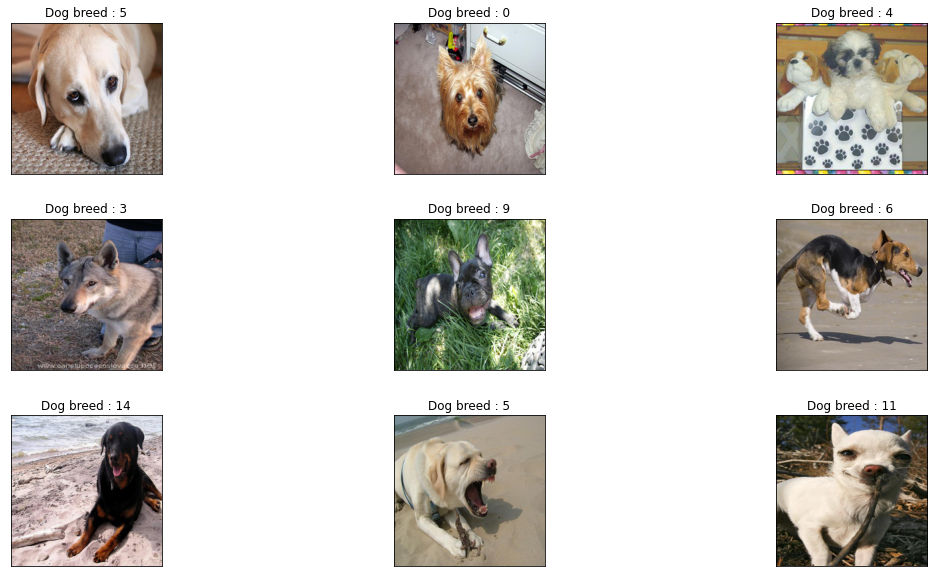

In [27]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Dog breed : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

One thing to notice is that resizing the images in this way causes distortion. We can see some of the dogs are squashed and stretched. We'll ignore this for now as DenseRef did and proceed with setting up the data.

For DenseNet to work, the data needs to be shuffled.

In [9]:
#Splitting testing and training sets
from keras.utils import to_categorical

random_seed = 42

images, labels = shuffle(images, labels )
images.resize((images.shape[0],224,224,3))


X_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.4,
                                                random_state=48)
Cat_test_y = np_utils.to_categorical(y_test)
y_train=np_utils.to_categorical(y_train)
print("x_train shape = ",X_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)
# set train Generator
datagen = ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)
datagen.fit(X_train)

x_train shape =  (1513, 224, 224, 3)
y_train shape =  (1513, 15)

x_test shape =  (1009, 224, 224, 3)
y_test shape =  (1009,)


Now the data is all set up, let's define our model for DenseNet.

## Defining DenseNet Model

In [28]:
#From https://github.com/TheAILearner/Densely-Connected-Convolutional-Networks/blob/master/DenseNet.py (as far as I can tell, sources are not properly credited where this code is used), used by DenseRef

import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D
from keras.optimizers import Adam



def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)

    return conv_x


def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters


def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters


def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
    input_img = Input(shape=(224,224,3))
    x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(x)

    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)

## Predicting with DenseNet

In [11]:
dense_block_size = 3
layers_in_block = 4

growth_rate = 12
classes = 15
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()


# training
batch_size = 32
epochs = 10
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, shuffle=True,validation_data=(x_test, Cat_test_y))

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 24) 648         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 24) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 24) 0           activation[0][0]                 
_______________________________________________________________________________________

In [19]:
#Testing Accuracy - converted to function for easier reruns
from sklearn import metrics
def dense_accuracy_test():
    label_pred = model.predict(x_test)

    pred = []
    for i in range(len(label_pred)):
        pred.append(np.argmax(label_pred[i]))

    Y_test = np.argmax(Cat_test_y, axis=1) # Convert one-hot to index


    print(metrics.classification_report(Y_test, pred))

    print(f"Accuracy Score: %{metrics.accuracy_score(Y_test, pred,normalize=False)}")
    return
dense_accuracy_test()

              precision    recall  f1-score   support

           0       0.04      0.86      0.08        70
           1       0.00      0.00      0.00        69
           2       0.00      0.00      0.00       110
           3       0.00      0.00      0.00        58
           4       0.00      0.00      0.00        71
           5       0.00      0.00      0.00        77
           6       0.12      0.01      0.02        81
           7       0.00      0.00      0.00        66
           8       0.00      0.00      0.00        58
           9       0.00      0.00      0.00        91
          10       0.00      0.00      0.00        70
          11       0.00      0.00      0.00        83
          12       0.00      0.00      0.00        75
          13       0.05      0.07      0.06        72
          14       0.00      0.00      0.00        60
          15       0.00      0.00      0.00        70
          16       0.00      0.00      0.00        63
          17       0.00    

DenseRef's implementation only produces 66% accuracy when run. Since we're using the same categories as Xception did, we can compare this to their 78% accuracy and say it doesn't seem to hold up. Let's try it again using the categories DenseRef originally did to see if we get better results more similar to their own reported accuracy of 98%.

Let's also take note of the runtime - ~24 minutes.

In [29]:
categories = os.listdir(images_dir)
categories = categories[:20]

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))


images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)

random_seed = 42

images, labels = shuffle(images, labels )
images.resize((images.shape[0],224,224,3))


X_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.4,
                                                random_state=48)
Cat_test_y = np_utils.to_categorical(y_test)
y_train=np_utils.to_categorical(y_train)
print("x_train shape = ",X_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)
# set train Generator
datagen = ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)
datagen.fit(X_train)

dense_block_size = 3
layers_in_block = 4

growth_rate = 12
classes = 20
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()


# training
batch_size = 32
epochs = 10
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, shuffle=True,validation_data=(x_test, Cat_test_y))

dense_accuracy_test()

No. of images loaded =  3633 
No. of labels loaded =  3633
Images shape =  (3633, 227, 227, 3) 
Labels shape =  (3633,)
x_train shape =  (2179, 224, 224, 3)
y_train shape =  (2179, 20)

x_test shape =  (1454, 224, 224, 3)
y_test shape =  (1454,)
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 224, 224, 24) 648         input_4[0][0]                    
__________________________________________________________________________________________________
activation_48 (Activation)      (None, 224, 224, 24) 0           conv2d_45[0][0]                  
_______________________________________

It achieved an 85% accuracy on the first 20 categories, which is better than on the 15 categories but not as comparable to the results of Xception because of the difference in the amount of data.

If we take a closer look, our model runs 69 steps per epoch. DenseRef's model ran 2019 steps per epoch which came from the shape of the data we saw earlier on (x_train shape = (2019, 224, 224, 3)). Given we've used the same implementation and parameter settings, ours should have run 2179 because our shape came out as x_tain shape =  (2179, 224, 224, 3). Another attempt at running their model by directly downloading their notebook and running it produced the same incompatible results. This is possibly due to some updates in the libraries used throughout, but it's difficult to diagnose exactly why this is happening.

To try to improve this, let's first try handling the problem with the data preprocessing. DenseRef didn't properly rescale the images which resulted in distortion, so let's fix that. We can use some of the methods tested out by XceptRef. We'll also reset the categories to the 15 breeds used by XceptRef for better comparison and assessment of results.

### Better Data Preprocessing and Augmentation

In [35]:
#From XceptRef
from keras.preprocessing import image

def preprocessing_cnn(directories, img_width, img_height):
    """Preprocessing of images in order to integrate them 
    into a convolutional neural network. Equalization, 
    Denoising and transformation of the image into Array. 
    Simultaneous creation of labels (y). 

    Parameters
    ---------------------------------------------------
    directoriesList : list
        List of files to be processed.
    img_width : integer
        width of the image to be reached for resizing
    img_height : integer
        height of the image to be reached for resizing
    ---------------------------------------------------
    """
    img_list=[]
    labels=[]
    for index, breed in enumerate(directories):
        for image_name in os.listdir(images_dir+"/"+breed):
            # Read image
            img = cv2.imread(images_dir+"/"+breed+"/"+image_name)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            # Resize image
            dim = (img_width, img_height)
            img = cv2.resize(img, dim, interpolation=cv2.INTER_LINEAR)
            # Equalization
            img_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
            img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
            img_equ = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
            # Apply non-local means filter on test img
            dst_img = cv2.fastNlMeansDenoisingColored(
                src=img_equ,
                dst=None,
                h=10,
                hColor=10,
                templateWindowSize=7,
                searchWindowSize=21)
            
            # Convert modified img to array
            img_array = image.img_to_array(dst_img)
            
            # Append lists of labels and images
            img_list.append(np.array(img_array))
            labels.append(breed.split("-")[1])
    
    return img_list, labels

#Setting Categories
categories = [
    'n02096294-Australian_terrier',
    'n02093256-Staffordshire_bullterrier',
    'n02099601-golden_retriever',
    'n02106662-German_shepherd',
    'n02086240-Shih-Tzu',
    'n02099712-Labrador_retriever',
    'n02088364-beagle',
    'n02100735-English_setter',
    'n02102318-cocker_spaniel',
    'n02108915-French_bulldog',
    'n02094433-Yorkshire_terrier',
    'n02085620-Chihuahua',
    'n02110185-Siberian_husky',
    'n02106166-Border_collie',
    'n02106550-Rottweiler']

# Define numbers of breeds to preprocess
num_breeds = len(categories) 

# Execute preprocessor on selection
# X = images
# y = labels
X, y = preprocessing_cnn(categories, 299, 299)
# Convert in numpy array
X = np.array(X)
y = np.array(y)
print("-" * 50)
print("Execution time for preprocessing :")
print("-" * 50)
print("Number of images preprocessed : {}"\
     .format(len(y)))
print("Shape of images np.array : {}"\
     .format(X.shape))

--------------------------------------------------
Execution time for preprocessing :
--------------------------------------------------
Number of images preprocessed : 2522
Shape of images np.array : (2522, 299, 299, 3)


### DenseNet on Preprocessed Data

In [36]:
images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))


images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)

random_seed = 42

images, labels = shuffle(images, labels )
images.resize((images.shape[0],224,224,3))


X_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.4,
                                                random_state=48)
Cat_test_y = np_utils.to_categorical(y_test)
y_train=np_utils.to_categorical(y_train)
print("x_train shape = ",X_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)
# set train Generator
datagen = ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)
datagen.fit(X_train)

dense_block_size = 3
layers_in_block = 4

growth_rate = 12
classes = 15
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()


# training
batch_size = 32
epochs = 10
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, shuffle=True,validation_data=(x_test, Cat_test_y))

dense_accuracy_test()

No. of images loaded =  2522 
No. of labels loaded =  2522
Images shape =  (2522, 227, 227, 3) 
Labels shape =  (2522,)
x_train shape =  (1513, 224, 224, 3)
y_train shape =  (1513, 15)

x_test shape =  (1009, 224, 224, 3)
y_test shape =  (1009,)
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 224, 224, 24) 648         input_5[0][0]                    
__________________________________________________________________________________________________
activation_64 (Activation)      (None, 224, 224, 24) 0           conv2d_60[0][0]                  
_______________________________________

Preprocessing and augmenting the data improved the accuracy to 76%, which is only 2% less than the Xception model on the same categories. However, Xception would still without a doubt be the preferred model because of its shorter runtime. It is true that DenseNet would run better with more examples to learn from (hence its better accuracy on the 20 categories), but it would also take longer and the same could be said of Xception.

For the sake of proper experimental methods, we'll test it again on randomized categories.

In [39]:
import random

categories = os.listdir(images_dir)
categories = random.sample(categories,15)

['n02091635-otterhound', 'n02094258-Norwich_terrier', 'n02089078-black-and-tan_coonhound', 'n02095889-Sealyham_terrier', 'n02085620-Chihuahua', 'n02086079-Pekinese', 'n02099849-Chesapeake_Bay_retriever', 'n02107574-Greater_Swiss_Mountain_dog', 'n02088094-Afghan_hound', 'n02090379-redbone', 'n02100236-German_short-haired_pointer', 'n02090721-Irish_wolfhound', 'n02094114-Norfolk_terrier', 'n02101006-Gordon_setter', 'n02113624-toy_poodle']


In [40]:
# Define numbers of breeds to preprocess
num_breeds = len(categories) 

# Execute preprocessor on selection
# X = images
# y = labels
X, y = preprocessing_cnn(categories, 299, 299)
# Convert in numpy array
X = np.array(X)
y = np.array(y)
print("-" * 50)
print("Execution time for preprocessing :")
print("-" * 50)
print("Number of images preprocessed : {}"\
     .format(len(y)))
print("Shape of images np.array : {}"\
     .format(X.shape))

--------------------------------------------------
Execution time for preprocessing :
--------------------------------------------------
Number of images preprocessed : 2566
Shape of images np.array : (2566, 299, 299, 3)


In [41]:
images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))


images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)

random_seed = 42

images, labels = shuffle(images, labels )
images.resize((images.shape[0],224,224,3))


X_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.4,
                                                random_state=48)
Cat_test_y = np_utils.to_categorical(y_test)
y_train=np_utils.to_categorical(y_train)
print("x_train shape = ",X_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)
# set train Generator
datagen = ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)
datagen.fit(X_train)

dense_block_size = 3
layers_in_block = 4

growth_rate = 12
classes = 15
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()


# training
batch_size = 32
epochs = 10
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, shuffle=True,validation_data=(x_test, Cat_test_y))

dense_accuracy_test()

No. of images loaded =  2566 
No. of labels loaded =  2566
Images shape =  (2566, 227, 227, 3) 
Labels shape =  (2566,)
x_train shape =  (1539, 224, 224, 3)
y_train shape =  (1539, 15)

x_test shape =  (1027, 224, 224, 3)
y_test shape =  (1027,)
Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 224, 224, 24) 648         input_6[0][0]                    
__________________________________________________________________________________________________
activation_80 (Activation)      (None, 224, 224, 24) 0           conv2d_75[0][0]                  
______________________________________

In [44]:
def random_sample():
    categories = os.listdir(images_dir)
    categories = random.sample(categories,15)
    num_breeds = len(categories) 

    # Execute preprocessor on selection
    # X = images
    # y = labels
    X, y = preprocessing_cnn(categories, 299, 299)
    # Convert in numpy array
    X = np.array(X)
    y = np.array(y)

    images, labels = load_images_and_labels(categories)
    print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))


    images = np.array(images)
    labels = np.array(labels)

    print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)

    random_seed = 42

    images, labels = shuffle(images, labels )
    images.resize((images.shape[0],224,224,3))


    X_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.4,
                                                    random_state=48)
    Cat_test_y = np_utils.to_categorical(y_test)
    y_train=np_utils.to_categorical(y_train)
    print("x_train shape = ",X_train.shape)
    print("y_train shape = ",y_train.shape)
    print("\nx_test shape = ",x_test.shape)
    print("y_test shape = ",y_test.shape)
    # set train Generator
    datagen = ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)
    datagen.fit(X_train)
    return

#random_sample() - running on same random sample as before to avoid the computation time of preprocessing the data
dense_block_size = 3
layers_in_block = 4

growth_rate = 12
classes = 15
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()


# training
batch_size = 32
epochs = 10

#CHANGED OPTIMIZER
optimizer = Adadelta(lr=0.0001, rho=0.95, epsilon=1e-08, )


model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, shuffle=True,validation_data=(x_test, Cat_test_y))

dense_accuracy_test()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 224, 224, 24) 648         input_8[0][0]                    
__________________________________________________________________________________________________
activation_112 (Activation)     (None, 224, 224, 24) 0           conv2d_105[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 112, 112, 24) 0           activation_112[0][0]             
______________________________________________________________________________________

In [46]:
dense_block_size = 3
layers_in_block = 4

growth_rate = 12
classes = 15
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()


# training
batch_size = 32
epochs = 10


#Wasn't useful- back to Adam

#Changed loss to categorical, makes more sense given this is a multi-class problem
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, shuffle=True,validation_data=(x_test, Cat_test_y))

dense_accuracy_test()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 224, 224, 24) 648         input_10[0][0]                   
__________________________________________________________________________________________________
activation_144 (Activation)     (None, 224, 224, 24) 0           conv2d_135[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 112, 112, 24) 0           activation_144[0][0]             
______________________________________________________________________________________

Changing the loss function to something more appropriate for this dataset appears to have drastically improved the accuracy.

In [47]:
dense_block_size = 3
layers_in_block = 4

growth_rate = 12
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()


# training
batch_size = 32
epochs = 10

#Adjusted learning rate
optimizer = Adam(lr=0.0001/10, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, shuffle=True,validation_data=(x_test, Cat_test_y))

dense_accuracy_test()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 224, 224, 24) 648         input_11[0][0]                   
__________________________________________________________________________________________________
activation_160 (Activation)     (None, 224, 224, 24) 0           conv2d_150[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 112, 112, 24) 0           activation_160[0][0]             
______________________________________________________________________________________

In [48]:
dense_block_size = 3
layers_in_block = 4

#Adjusted growth rate
growth_rate = 14
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()


# training
batch_size = 32
epochs = 10

#Reset learning rate
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, shuffle=True,validation_data=(x_test, Cat_test_y))

dense_accuracy_test()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_165 (Conv2D)             (None, 224, 224, 24) 648         input_12[0][0]                   
__________________________________________________________________________________________________
activation_176 (Activation)     (None, 224, 224, 24) 0           conv2d_165[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 112, 112, 24) 0           activation_176[0][0]             
______________________________________________________________________________________

Increasing the growth rate improved the accuracy. however, each epoch took 20 more seconds. The extra 3 minutes is a decent trade-off.

In [49]:
dense_block_size = 3
layers_in_block = 4

#Keep adjusted growth rate
growth_rate = 14
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()


# training
#Increase batch size
batch_size = 35
epochs = 10


optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, shuffle=True,validation_data=(x_test, Cat_test_y))

dense_accuracy_test()

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_180 (Conv2D)             (None, 224, 224, 24) 648         input_13[0][0]                   
__________________________________________________________________________________________________
activation_192 (Activation)     (None, 224, 224, 24) 0           conv2d_180[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 112, 112, 24) 0           activation_192[0][0]             
______________________________________________________________________________________

##### 99% accuracy! Testing again on a different randomized sample for experimental validity (make sure it's not a fluke)

In [50]:
random_sample()

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, shuffle=True,validation_data=(x_test, Cat_test_y))

dense_accuracy_test()

No. of images loaded =  2628 
No. of labels loaded =  2628
Images shape =  (2628, 227, 227, 3) 
Labels shape =  (2628,)
x_train shape =  (1576, 224, 224, 3)
y_train shape =  (1576, 15)

x_test shape =  (1052, 224, 224, 3)
y_test shape =  (1052,)
Epoch 1/10
49/49 [==============================] - 168s 3s/step - loss: 2.6366 - accuracy: 0.1092 - val_loss: 2.7485 - val_accuracy: 0.0915
Epoch 2/10
49/49 [==============================] - 167s 3s/step - loss: 2.6220 - accuracy: 0.1326 - val_loss: 2.7548 - val_accuracy: 0.0837
Epoch 3/10
49/49 [==============================] - 167s 3s/step - loss: 2.6176 - accuracy: 0.1397 - val_loss: 2.7599 - val_accuracy: 0.0847
Epoch 4/10
49/49 [==============================] - 167s 3s/step - loss: 2.6125 - accuracy: 0.1391 - val_loss: 2.7582 - val_accuracy: 0.0837
Epoch 5/10
49/49 [==============================] - 167s 3s/step - loss: 2.6103 - accuracy: 0.1326 - val_loss: 2.7652 - val_accuracy: 0.0925
Epoch 6/10
49/49 [==============================]

Not as good. Increased time for last 3 epochs (and first 3 of the next test) was due to another program using up some of my CPU.

In [51]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, shuffle=True,validation_data=(x_test, Cat_test_y))

dense_accuracy_test()

Epoch 1/10
49/49 [==============================] - 206s 4s/step - loss: 2.5877 - accuracy: 0.1391 - val_loss: 2.7839 - val_accuracy: 0.0818
Epoch 2/10
49/49 [==============================] - 207s 4s/step - loss: 2.5768 - accuracy: 0.1533 - val_loss: 2.7880 - val_accuracy: 0.0779
Epoch 3/10
49/49 [==============================] - 182s 4s/step - loss: 2.5705 - accuracy: 0.1585 - val_loss: 2.7870 - val_accuracy: 0.0769
Epoch 4/10
49/49 [==============================] - 177s 4s/step - loss: 2.5694 - accuracy: 0.1553 - val_loss: 2.7980 - val_accuracy: 0.0711
Epoch 5/10
49/49 [==============================] - 178s 4s/step - loss: 2.5631 - accuracy: 0.1598 - val_loss: 2.7994 - val_accuracy: 0.0730
Epoch 6/10
49/49 [==============================] - 177s 4s/step - loss: 2.5586 - accuracy: 0.1702 - val_loss: 2.8015 - val_accuracy: 0.0779
Epoch 7/10
49/49 [==============================] - 178s 4s/step - loss: 2.5591 - accuracy: 0.1566 - val_loss: 2.8071 - val_accuracy: 0.0740
Epoch 8/10
49

Rerunning on the same sample to check consistency, 2% improved, nothing notable. Test a third random sample.

In [52]:
random_sample()

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, shuffle=True,validation_data=(x_test, Cat_test_y))

dense_accuracy_test()

No. of images loaded =  2579 
No. of labels loaded =  2579
Images shape =  (2579, 227, 227, 3) 
Labels shape =  (2579,)
x_train shape =  (1547, 224, 224, 3)
y_train shape =  (1547, 15)

x_test shape =  (1032, 224, 224, 3)
y_test shape =  (1032,)
Epoch 1/10
49/49 [==============================] - 171s 3s/step - loss: 2.5481 - accuracy: 0.1566 - val_loss: 2.8193 - val_accuracy: 0.0750
Epoch 2/10
49/49 [==============================] - 171s 3s/step - loss: 2.5359 - accuracy: 0.1819 - val_loss: 2.8165 - val_accuracy: 0.0721
Epoch 3/10
49/49 [==============================] - 171s 3s/step - loss: 2.5332 - accuracy: 0.1832 - val_loss: 2.8172 - val_accuracy: 0.0701
Epoch 4/10
49/49 [==============================] - 170s 3s/step - loss: 2.5314 - accuracy: 0.1754 - val_loss: 2.8161 - val_accuracy: 0.0721
Epoch 5/10
49/49 [==============================] - 170s 3s/step - loss: 2.5200 - accuracy: 0.1858 - val_loss: 2.8259 - val_accuracy: 0.0740
Epoch 6/10
49/49 [==============================]

In [53]:
dense_block_size = 3
layers_in_block = 4

#Increase growth by 1
growth_rate = 15
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()


# training
#Increase epochs by 1
batch_size = 35
epochs = 11


optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, shuffle=True,validation_data=(x_test, Cat_test_y))

dense_accuracy_test()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_195 (Conv2D)             (None, 224, 224, 24) 648         input_14[0][0]                   
__________________________________________________________________________________________________
activation_208 (Activation)     (None, 224, 224, 24) 0           conv2d_195[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 112, 112, 24) 0           activation_208[0][0]             
______________________________________________________________________________________

That didn't do much. Deep learning works better on more data, which explains why it performed better on 20 categories compared to 15. We were using 15 to compare better with XceptRef, but now that we've established some comparisons, we can try applying the parameters that worked best to more data to see if it improves the performance. We achieved high performance once already, but it was inconsistent, so we're looking to evaluate and improve the consistency. We'll also note that running this algorithm on 15 categories took about 28.3 minutes so we can establish the increased time required to train more categories (not factoring in the amount of time required to preprocess the data).

In [54]:
def random_sample_sizen(n):
    classes = n
    categories = os.listdir(images_dir)
    categories = random.sample(categories,n)
    num_breeds = len(categories) 

    # Execute preprocessor on selection
    # X = images
    # y = labels
    X, y = preprocessing_cnn(categories, 299, 299)
    # Convert in numpy array
    X = np.array(X)
    y = np.array(y)

    images, labels = load_images_and_labels(categories)
    print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))


    images = np.array(images)
    labels = np.array(labels)

    print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)

    random_seed = 42

    images, labels = shuffle(images, labels )
    images.resize((images.shape[0],224,224,3))


    X_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.4,
                                                    random_state=48)
    Cat_test_y = np_utils.to_categorical(y_test)
    y_train=np_utils.to_categorical(y_train)
    print("x_train shape = ",X_train.shape)
    print("y_train shape = ",y_train.shape)
    print("\nx_test shape = ",x_test.shape)
    print("y_test shape = ",y_test.shape)
    # set train Generator
    datagen = ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)
    datagen.fit(X_train)
    return

random_sample_sizen(20)

dense_block_size = 3
layers_in_block = 4

#Reset to 99% achieved version
growth_rate = 14
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()


# training

batch_size = 35
epochs = 10


optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, shuffle=True,validation_data=(x_test, Cat_test_y))

dense_accuracy_test()

No. of images loaded =  3509 
No. of labels loaded =  3509
Images shape =  (3509, 227, 227, 3) 
Labels shape =  (3509,)
x_train shape =  (2105, 224, 224, 3)
y_train shape =  (2105, 20)

x_test shape =  (1404, 224, 224, 3)
y_test shape =  (1404,)
Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_210 (Conv2D)             (None, 224, 224, 24) 648         input_15[0][0]                   
__________________________________________________________________________________________________
activation_224 (Activation)     (None, 224, 224, 24) 0           conv2d_210[0][0]                 
______________________________________

It only achieved 71% accuracy on the 20 random categories. We'll try it again first on the 15 pre-selected categories used by Xception, save the model, and continue with this pretrained version.

In [55]:
classes = 15
categories = os.listdir(images_dir)
categories = [
    'n02096294-Australian_terrier',
    'n02093256-Staffordshire_bullterrier',
    'n02099601-golden_retriever',
    'n02106662-German_shepherd',
    'n02086240-Shih-Tzu',
    'n02099712-Labrador_retriever',
    'n02088364-beagle',
    'n02100735-English_setter',
    'n02102318-cocker_spaniel',
    'n02108915-French_bulldog',
    'n02094433-Yorkshire_terrier',
    'n02085620-Chihuahua',
    'n02110185-Siberian_husky',
    'n02106166-Border_collie',
    'n02106550-Rottweiler']
num_breeds = len(categories) 
X, y = preprocessing_cnn(categories, 299, 299)
X = np.array(X)
y = np.array(y)

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))


images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)

random_seed = 42

images, labels = shuffle(images, labels )
images.resize((images.shape[0],224,224,3))


X_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.4,
                                                    random_state=48)
Cat_test_y = np_utils.to_categorical(y_test)
y_train=np_utils.to_categorical(y_train)
print("x_train shape = ",X_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

datagen = ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)
datagen.fit(X_train)


model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, shuffle=True,validation_data=(x_test, Cat_test_y))

dense_accuracy_test()

No. of images loaded =  2522 
No. of labels loaded =  2522
Images shape =  (2522, 227, 227, 3) 
Labels shape =  (2522,)
x_train shape =  (1513, 224, 224, 3)
y_train shape =  (1513, 15)

x_test shape =  (1009, 224, 224, 3)
y_test shape =  (1009,)
Model: "functional_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_225 (Conv2D)             (None, 224, 224, 24) 648         input_16[0][0]                   
__________________________________________________________________________________________________
activation_240 (Activation)     (None, 224, 224, 24) 0           conv2d_225[0][0]                 
______________________________________

Save the model to finetune it to try to achieve something similar to that 99% because I didn't realize I should be saving the model until after that model had already been overwritten.

In [58]:

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, shuffle=True,validation_data=(x_test, Cat_test_y),callbacks=[cp_callback])

dense_accuracy_test()

Epoch 1/10
48/48 [==============================] - ETA: 0s - loss: 2.6030 - accuracy: 0.1328
Epoch 00001: saving model to training_1\cp.ckpt
48/48 [==============================] - 176s 4s/step - loss: 2.6030 - accuracy: 0.1328 - val_loss: 2.7653 - val_accuracy: 0.0684
Epoch 2/10
48/48 [==============================] - ETA: 0s - loss: 2.5979 - accuracy: 0.1408
Epoch 00002: saving model to training_1\cp.ckpt
48/48 [==============================] - 174s 4s/step - loss: 2.5979 - accuracy: 0.1408 - val_loss: 2.7736 - val_accuracy: 0.0634
Epoch 3/10
48/48 [==============================] - ETA: 0s - loss: 2.5939 - accuracy: 0.1474
Epoch 00003: saving model to training_1\cp.ckpt
48/48 [==============================] - 175s 4s/step - loss: 2.5939 - accuracy: 0.1474 - val_loss: 2.7721 - val_accuracy: 0.0674
Epoch 4/10
48/48 [==============================] - ETA: 0s - loss: 2.5835 - accuracy: 0.1599
Epoch 00004: saving model to training_1\cp.ckpt
48/48 [==============================] - 1

In [59]:
model.save('DenseNet-tuned')
#Tensorflow's documentation says it's safe to ignore these warnings.

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: DenseNet-tuned\assets


In [61]:
model.trainable = True
print("Number of layers in the base model: ", len(model.layers))
fine_tune_at = 50
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False
fine_tune_optimizer = Adam(lr=0.0001/10, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy',optimizer = fine_tune_optimizer,metrics=['accuracy'])

fine_tune_epochs = 5
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(X_train,y_train, epochs=total_epochs, initial_epoch=history.epoch[-1],validation_data=(x_test, Cat_test_y),callbacks=[cp_callback])

Number of layers in the base model:  76
Epoch 10/15
48/48 [==============================] - ETA: 0s - loss: 2.5264 - accuracy: 0.1923
Epoch 00010: saving model to training_1\cp.ckpt
48/48 [==============================] - 65s 1s/step - loss: 2.5264 - accuracy: 0.1923 - val_loss: 2.7830 - val_accuracy: 0.0763
Epoch 11/15
48/48 [==============================] - ETA: 0s - loss: 2.5221 - accuracy: 0.1930
Epoch 00011: saving model to training_1\cp.ckpt
48/48 [==============================] - 64s 1s/step - loss: 2.5221 - accuracy: 0.1930 - val_loss: 2.7837 - val_accuracy: 0.0743
Epoch 12/15
48/48 [==============================] - ETA: 0s - loss: 2.5211 - accuracy: 0.1910
Epoch 00012: saving model to training_1\cp.ckpt
48/48 [==============================] - 64s 1s/step - loss: 2.5211 - accuracy: 0.1910 - val_loss: 2.7849 - val_accuracy: 0.0773
Epoch 13/15
48/48 [==============================] - ETA: 0s - loss: 2.5216 - accuracy: 0.1851
Epoch 00013: saving model to training_1\cp.ckpt
4

In [62]:
dense_accuracy_test()

              precision    recall  f1-score   support

           0       0.05      0.14      0.07        71
           1       0.05      0.06      0.06        49
           2       0.00      0.00      0.00        65
           3       0.15      0.03      0.05        62
           4       0.10      0.38      0.16        86
           5       0.07      0.06      0.06        69
           6       0.09      0.09      0.09        77
           7       0.09      0.03      0.04        66
           8       0.25      0.01      0.03        68
           9       0.07      0.04      0.05        57
          10       0.00      0.00      0.00        73
          11       0.00      0.00      0.00        66
          12       0.07      0.11      0.09        83
          13       0.07      0.05      0.06        57
          14       0.00      0.00      0.00        60

    accuracy                           0.08      1009
   macro avg       0.07      0.07      0.05      1009
weighted avg       0.07   